In [70]:
# bibliotecas
import scipy.io
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

In [71]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('Turbidez_Tres_Marias_2_Classes_25NTU_InterquartilSuperiorTresMarias4_Datasets_Filtro_Ruidos_DiferencaAte2Dias_Sem_Corte_Outliers_196_NTU.csv', delimiter=',')
#df_mask = data['Dominio'] == 'PMQs'
#data = data[df_mask]
df_filtro = data #data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
# df['Classe'] = df['Classe'] - 1
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
0,337.0,338.0,503.0,193.0,158.0,102.0,100.0,82.0,77.0,55.0,43.0,25.0,0
1,437.0,449.0,530.0,308.0,275.0,209.0,229.0,206.0,226.0,206.0,267.0,238.0,0
2,473.0,524.0,683.0,399.0,369.0,264.0,260.0,272.0,248.0,207.0,244.0,215.0,0
3,334.0,337.0,485.0,184.0,143.0,80.0,83.0,74.0,73.0,67.0,57.0,44.0,0
4,332.0,327.0,494.0,175.0,144.0,90.0,95.0,78.0,74.0,55.0,44.0,33.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,445.0,646.0,721.0,427.0,369.0,199.0,223.0,410.0,223.0,319.0,337.0,319.0,0
698,325.0,302.0,394.0,135.0,104.0,68.0,76.0,54.0,62.0,9.0,21.0,10.0,0
699,923.0,677.0,874.0,519.0,591.0,626.0,717.0,416.0,708.0,1962.0,485.0,518.0,0
700,344.0,386.0,657.0,332.0,262.0,135.0,134.0,110.0,101.0,139.0,47.0,35.0,0


In [72]:
# apagar linhas duplicatas
df = df.drop_duplicates(['BAND_1','BAND_2','BAND_3'])
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
0,337.0,338.0,503.0,193.0,158.0,102.0,100.0,82.0,77.0,55.0,43.0,25.0,0
1,437.0,449.0,530.0,308.0,275.0,209.0,229.0,206.0,226.0,206.0,267.0,238.0,0
2,473.0,524.0,683.0,399.0,369.0,264.0,260.0,272.0,248.0,207.0,244.0,215.0,0
3,334.0,337.0,485.0,184.0,143.0,80.0,83.0,74.0,73.0,67.0,57.0,44.0,0
4,332.0,327.0,494.0,175.0,144.0,90.0,95.0,78.0,74.0,55.0,44.0,33.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,445.0,646.0,721.0,427.0,369.0,199.0,223.0,410.0,223.0,319.0,337.0,319.0,0
698,325.0,302.0,394.0,135.0,104.0,68.0,76.0,54.0,62.0,9.0,21.0,10.0,0
699,923.0,677.0,874.0,519.0,591.0,626.0,717.0,416.0,708.0,1962.0,485.0,518.0,0
700,344.0,386.0,657.0,332.0,262.0,135.0,134.0,110.0,101.0,139.0,47.0,35.0,0


In [73]:
# contar classes
print('Quantidade por classe:')
print(df['Classe'].value_counts())

# filtrar por classe
df_1 = df[df['Classe']==0]
df_2 = df[df['Classe']==1]
df_3 = df[df['Classe']==2]
df_4 = df[df['Classe']==3]
#df_5 = df[df['Classe']==5]
#df_6 = df[df['Classe']==6]

Quantidade por classe:
0    676
1     26
Name: Classe, dtype: int64


In [74]:
# deixar classe 0 como sendo anomalia e o o resto como normal
df_anomalia = df_2 #pd.concat([df_2, df_3, df_4])
df_normal = df_1
df_anomalia.loc[:,'Classe'] = 1
df_normal.loc[:,'Classe'] = 0

print('Quantidade por classe:')
print(df_normal['Classe'].value_counts())
print(df_anomalia['Classe'].value_counts())

Quantidade por classe:
0    676
Name: Classe, dtype: int64
1    26
Name: Classe, dtype: int64


In [75]:
#separar treino e teste
qtd_amostras_treino = 676-26

randomlist = random.sample(range(0, df_normal.shape[0]), qtd_amostras_treino)
df_normal_train = df_normal.iloc[randomlist]
df_normal_test = df_normal.drop(df_normal.index[randomlist])

df_anomalia_test = df_anomalia

print('Classe 1 - treino:', df_normal_train.shape[0], '/ teste:', df_normal_test.shape[0])
print('Classe 2 - teste:', df_anomalia_test.shape[0])

Classe 1 - treino: 650 / teste: 26
Classe 2 - teste: 26


In [76]:
# concatenar dataframes
df_train = df_normal_train
frames_test = [df_normal_test, df_anomalia_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (650, 12) / rotulos: (650,)
Tamanho test: (52, 12) / rotulos: (52,)


In [77]:
# aumentar tamanho da classe minoritaria para o smote funcionar
df_anomalia_grande = pd.concat([df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, 
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, 
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, 
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, 
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, 
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test,
                               df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test, df_anomalia_test])
x_anomalia_grande = df_anomalia_grande.to_numpy()[:,:12]
y_anomalia_grande = df_anomalia_grande.to_numpy()[:,12].astype(int)
df_anomalia_grande

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
250,528.0,744.0,1478.0,1939.0,1785.0,724.0,704.0,525.0,390.0,94.0,46.0,41.0,1
257,530.0,802.0,1556.0,2117.0,2020.0,853.0,874.0,661.0,452.0,110.0,42.0,32.0,1
262,428.0,605.0,1100.0,682.0,546.0,158.0,167.0,125.0,88.0,36.0,35.0,25.0,1
265,804.0,975.0,1452.0,1301.0,1027.0,344.0,320.0,418.0,173.0,229.0,199.0,170.0,1
267,485.0,699.0,1329.0,1608.0,1393.0,489.0,516.0,392.0,277.0,93.0,117.0,113.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,420.0,574.0,1049.0,751.0,635.0,191.0,196.0,135.0,107.0,49.0,39.0,27.0,1
512,1016.0,1099.0,1712.0,1524.0,1224.0,402.0,365.0,293.0,203.0,233.0,52.0,43.0,1
514,696.0,703.0,1064.0,1397.0,1466.0,959.0,978.0,741.0,639.0,291.0,70.0,74.0,1
521,776.0,955.0,1748.0,2364.0,2245.0,932.0,955.0,696.0,526.0,85.0,98.0,91.0,1


In [78]:
# unir o treinamento de amostra normal com o criado de anomalia para aplicacao do smote
x_antes_smote = np.concatenate((X_train, x_anomalia_grande), axis=0)
y_antes_smote = np.concatenate((y_train, y_anomalia_grande), axis=0)
print(x_antes_smote.shape)
print(y_antes_smote.shape)

(2860, 12)
(2860,)


In [79]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
x_apos_smote, y_apos_smote = oversample.fit_resample(x_antes_smote, y_antes_smote)
print(x_apos_smote.shape)
print(np.array(np.unique(y_apos_smote, return_counts=True)).T)

(4420, 12)
[[   0 2210]
 [   1 2210]]


In [80]:
indices_apagar=[]
for i in range(len(y_apos_smote)):
    if(y_apos_smote[i]==1):
        indices_apagar.append(i)

In [81]:
X_train2 = np.delete(x_apos_smote, indices_apagar, axis=0)
X_train2.shape

(2210, 12)

In [82]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train2)
norm_X_test = scaler.transform(X_test)

In [ ]:
'''# pca

import plotly.express as px
from sklearn.decomposition import PCA

X = df.loc[:, df.columns != 'Classe']

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Classe'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# SVM One Class

In [83]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
nu = [0.01, 0.1, 0.5, 0.8, 0.99]

resultados_svm = []

for a in tqdm(kernel):
    for b in gamma:
        for c in nu:
            grid_svm = OneClassSVM(kernel=a, gamma=b, nu=c)
            grid_svm.fit(norm_X_train)
            grid_svm_predictions = grid_svm.predict(norm_X_test)
            grid_svm_predictions[grid_svm_predictions == 1] = 0
            grid_svm_predictions[grid_svm_predictions == -1] = 1
            #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
            resultados_svm.append(a)
            resultados_svm.append(b)
            resultados_svm.append(c)
            resultados_svm.append(accuracy_score(y_test, grid_svm_predictions))
            resultados_svm.append(precision_score(y_test, grid_svm_predictions))
            resultados_svm.append(recall_score(y_test, grid_svm_predictions))
            resultados_svm.append(f1_score(y_test, grid_svm_predictions))
            
resultados_svm_df = pd.DataFrame(np.array(resultados_svm).reshape((int(len(resultados_svm)/7), 7)), columns=['kernel', 'gamma', 'nu', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_svm_df.sort_values('F1-score', ascending = False)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


,kernel,gamma,nu,acuracia,precisao,revocacao,F1-score
21,rbf,scale,0.1,0.9615384615384616,0.9615384615384616,0.9615384615384616,0.9615384615384616
26,rbf,auto,0.1,0.9615384615384616,0.9615384615384616,0.9615384615384616,0.9615384615384616
20,rbf,scale,0.01,0.9230769230769231,1.0,0.8461538461538461,0.9166666666666666
25,rbf,auto,0.01,0.9230769230769231,1.0,0.8461538461538461,0.9166666666666666
36,sigmoid,auto,0.1,0.8076923076923077,0.9,0.6923076923076923,0.7826086956521738
31,sigmoid,scale,0.1,0.8076923076923077,0.9,0.6923076923076923,0.7826086956521738
27,rbf,auto,0.5,0.7115384615384616,0.6341463414634146,1.0,0.7761194029850745
22,rbf,scale,0.5,0.7115384615384616,0.6341463414634146,1.0,0.7761194029850745
37,sigmoid,auto,0.5,0.6923076923076923,0.65625,0.8076923076923077,0.7241379310344829
32,sigmoid,scale,0.5,0.6923076923076923,0.65625,0.8076923076923077,0.7241379310344829


# Florestas isoladas

In [15]:
n_estimators= list(range(100, 800, 25))
max_samples= list(range(100, 500, 25))
contamination= [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
max_features= [1, 3, 7 ,10, 12]
bootstrap= [True, False]

resultados_if = []

for a in tqdm(n_estimators):
    for b in max_samples:
        for c in contamination:
            for d in max_features:
                for e in bootstrap:
                    grid_if = IsolationForest(n_estimators=a, max_samples=b, contamination=c, max_features=d, bootstrap=e ,n_jobs=-1)
                    grid_if.fit(norm_X_train)
                    grid_if_predictions = grid_if.predict(norm_X_test)
                    grid_if_predictions[grid_if_predictions == 1] = 0
                    grid_if_predictions[grid_if_predictions == -1] = 1
                    #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
                    resultados_if.append(a)
                    resultados_if.append(b)
                    resultados_if.append(c)
                    resultados_if.append(d)
                    resultados_if.append(e)
                    resultados_if.append(accuracy_score(y_test, grid_if_predictions))
                    resultados_if.append(precision_score(y_test, grid_if_predictions))
                    resultados_if.append(recall_score(y_test, grid_if_predictions))
                    resultados_if.append(f1_score(y_test, grid_if_predictions))
            
resultados_if_df = pd.DataFrame(np.array(resultados_if).reshape((int(len(resultados_if)/9), 9)), columns=['n_estimators', 'max_samples', 'contamination', 'max_features', 'bootstrap', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_if_df.sort_values('F1-score', ascending = False)

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [7:03:57<00:00, 908.50s/it]


,n_estimators,max_samples,contamination,max_features,bootstrap,acuracia,precisao,revocacao,F1-score
795,100.0,375.0,0.100,7.0,0.0,0.942308,0.896552,1.000000,0.945455
519,100.0,275.0,0.100,12.0,0.0,0.923077,0.866667,1.000000,0.928571
2895,150.0,325.0,0.100,7.0,0.0,0.923077,0.866667,1.000000,0.928571
1845,125.0,350.0,0.100,7.0,0.0,0.923077,0.892857,0.961538,0.925926
2055,125.0,425.0,0.100,7.0,0.0,0.923077,0.892857,0.961538,0.925926
...,...,...,...,...,...,...,...,...,...
18272,500.0,225.0,0.001,3.0,1.0,0.500000,0.000000,0.000000,0.000000
18271,500.0,225.0,0.001,1.0,0.0,0.500000,0.000000,0.000000,0.000000
18270,500.0,225.0,0.001,1.0,1.0,0.500000,0.000000,0.000000,0.000000
18209,500.0,200.0,0.001,12.0,0.0,0.500000,0.000000,0.000000,0.000000



Acuracia: 0.9423076923076923
Precisao: 0.9259259259259259
Recall: 0.9615384615384616
F1-score: 0.9433962264150944


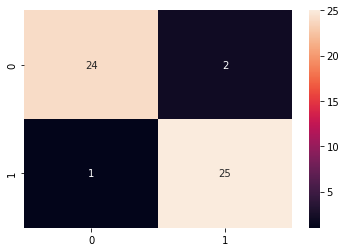

In [84]:
# pegar melhor modelo das florestas isoladas

best_model_if = IsolationForest(n_estimators=100,
                                max_samples=375,
                                contamination=0.1,
                                max_features=7,
                                bootstrap=0
                               ).fit(norm_X_train)

#################################

# salvar o modelo no disco
#pickle.dump(grid_if, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_if_predictions = best_model_if.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia:', accuracy_score(y_test, grid_if_predictions))
print('Precisao:', precision_score(y_test, grid_if_predictions))
print('Recall:', recall_score(y_test, grid_if_predictions))
print('F1-score:', f1_score(y_test, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
#print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# Inferencia para gerar mapa de tres marias

In [99]:
# fazer inferencia com o mapa gerado em cada um das amostras
mapa_df = pd.read_pickle("../2022-09-30-gerar mapa/220929_mapa_tres_marias/mapa.pkl")

mapa_bandas=mapa_df[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']]
mapa_bandas2 = mapa_bandas*10000
norm_X_mapa = scaler.transform(mapa_bandas2)
print("Tamanho mapa:", norm_X_mapa.shape)

# testar
grid_if_predictions_mapa = best_model_if.predict(norm_X_mapa)
# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions_mapa[grid_if_predictions_mapa == 1] = 0
grid_if_predictions_mapa[grid_if_predictions_mapa == -1] = 1

Tamanho mapa: (2132649, 12)


In [100]:
print(np.array(np.unique(grid_if_predictions_mapa, return_counts=True)).T)
#grid_if_predictions_mapa

[[      0 1125326]
 [      1 1007323]]


In [101]:
df_coord_class = mapa_df
df_coord_class['classe'] = grid_if_predictions_mapa.tolist()
df_coord_class = df_coord_class[['geometry','classe']]

df_coord_class

,geometry,classe
0,"POLYGON ((466540.000 7988920.000, 466540.000 7...",1
1,"POLYGON ((466560.000 7988920.000, 466560.000 7...",1
2,"POLYGON ((466580.000 7988920.000, 466580.000 7...",1
3,"POLYGON ((466540.000 7988900.000, 466540.000 7...",1
4,"POLYGON ((466560.000 7988900.000, 466560.000 7...",1
...,...,...
2132644,"POLYGON ((488420.000 7892380.000, 488420.000 7...",1
2132645,"POLYGON ((488440.000 7892380.000, 488440.000 7...",1
2132646,"POLYGON ((488460.000 7892380.000, 488460.000 7...",1
2132647,"POLYGON ((488180.000 7892360.000, 488180.000 7...",1


Text(0.5, 1.0, 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

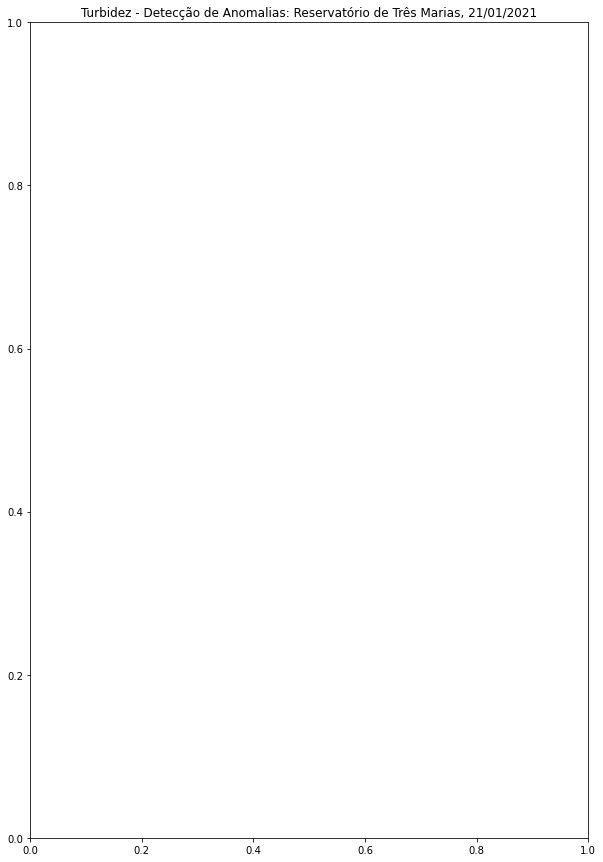

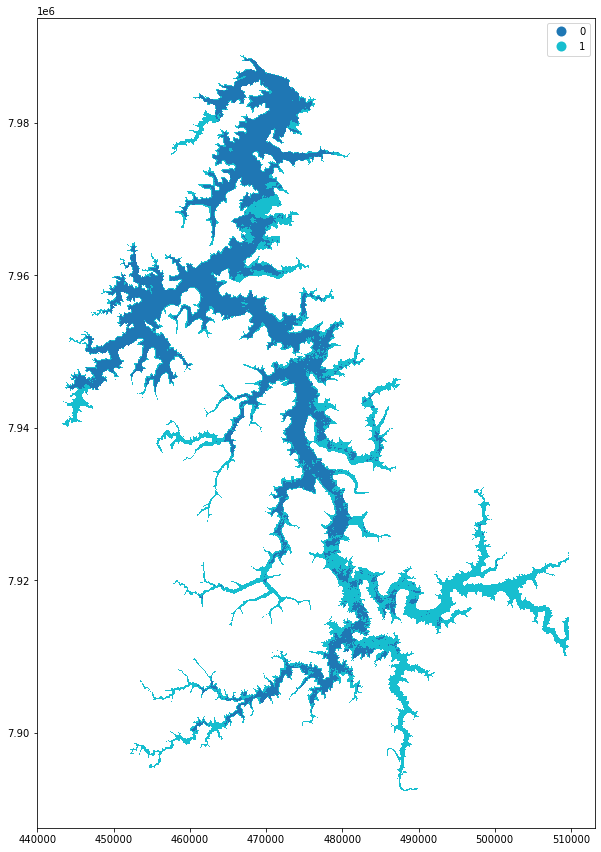

In [102]:
import geopandas as gpd
geodataframe_class = gpd.GeoDataFrame(df_coord_class, geometry='geometry')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,15

fig, ax = plt.subplots(1, 1) # depois vou colocar mais um eixo, eu acho... sei lá
geodataframe_class.plot(column='classe', legend = True, categorical= True)
ax.set_title( 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

In [103]:
geodataframe_class.to_file('Turbidez_Anomalias_25NTU_TresMarias.shp', driver='ESRI Shapefile')

# Inferencia para mapa que possivelmente tem baixa turbidez

In [94]:
# fazer inferencia com o mapa gerado em cada um das amostras
mapa_df = pd.read_pickle("../2022-09-30-gerar mapa/221011_mapa_baixa_turbidez/221011_mapa_baixa_turbidez.pkl")

mapa_bandas=mapa_df[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']]
mapa_bandas2 = mapa_bandas*10000
norm_X_mapa = scaler.transform(mapa_bandas2)
print("Tamanho mapa:", norm_X_mapa.shape)

# testar
grid_if_predictions_mapa = best_model_if.predict(norm_X_mapa)
# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions_mapa[grid_if_predictions_mapa == 1] = 0
grid_if_predictions_mapa[grid_if_predictions_mapa == -1] = 1

Tamanho mapa: (2132649, 12)


In [95]:
print(np.array(np.unique(grid_if_predictions_mapa, return_counts=True)).T)
#grid_if_predictions_mapa

[[      0 1735935]
 [      1  396714]]


In [96]:
df_coord_class = mapa_df
df_coord_class['classe'] = grid_if_predictions_mapa.tolist()
df_coord_class = df_coord_class[['geometry','classe']]

df_coord_class

,geometry,classe
0,"POLYGON ((466540.000 7988920.000, 466540.000 7...",1
1,"POLYGON ((466560.000 7988920.000, 466560.000 7...",1
2,"POLYGON ((466580.000 7988920.000, 466580.000 7...",1
3,"POLYGON ((466540.000 7988900.000, 466540.000 7...",1
4,"POLYGON ((466560.000 7988900.000, 466560.000 7...",1
...,...,...
2132644,"POLYGON ((488420.000 7892380.000, 488420.000 7...",1
2132645,"POLYGON ((488440.000 7892380.000, 488440.000 7...",1
2132646,"POLYGON ((488460.000 7892380.000, 488460.000 7...",1
2132647,"POLYGON ((488180.000 7892360.000, 488180.000 7...",1


Text(0.5, 1.0, 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

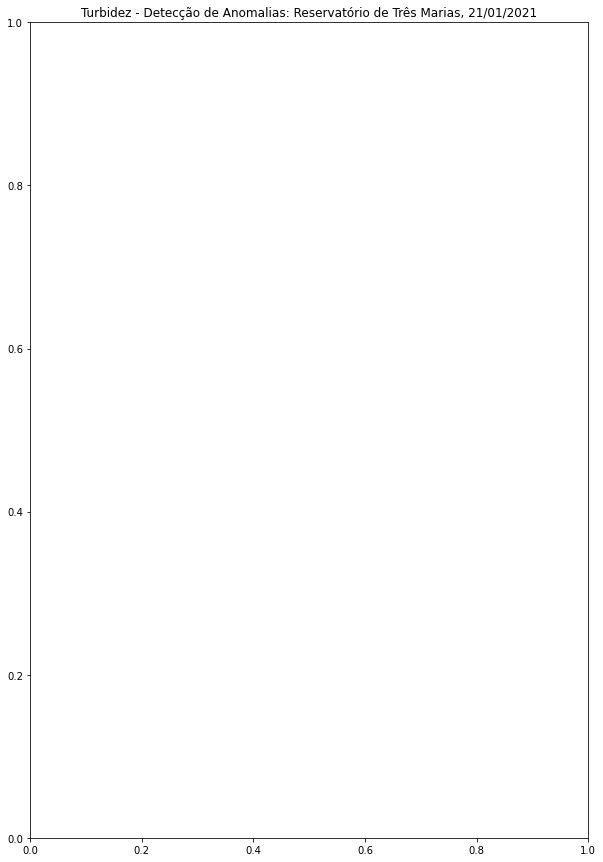

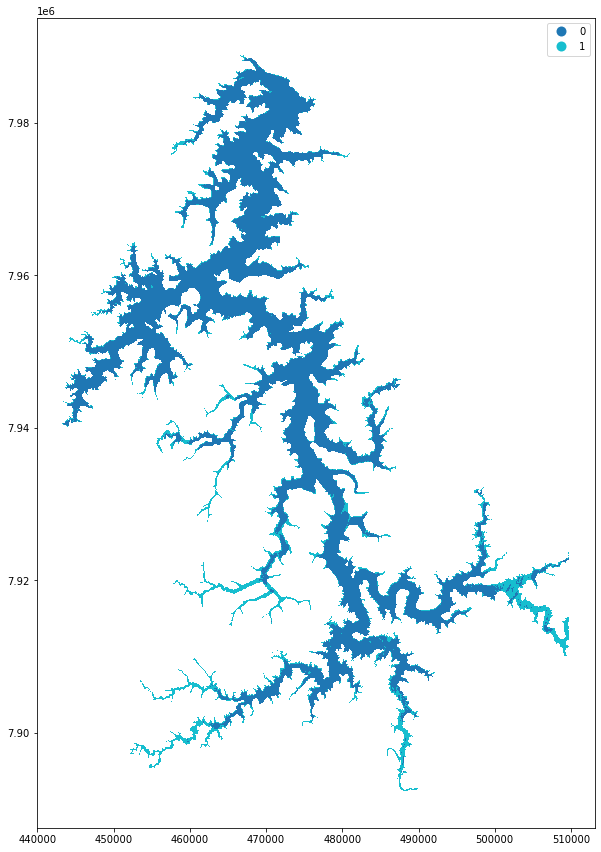

In [97]:
import geopandas as gpd
geodataframe_class = gpd.GeoDataFrame(df_coord_class, geometry='geometry')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,15

fig, ax = plt.subplots(1, 1) # depois vou colocar mais um eixo, eu acho... sei lá
geodataframe_class.plot(column='classe', legend = True, categorical= True)
ax.set_title( 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

In [98]:
geodataframe_class.to_file('Baixa_Turbidez_Anomalias_25NTU_TresMarias.shp', driver='ESRI Shapefile')

In [18]:
######### DADOS PAMPULHA

# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('dataset_pampulha_filtro_nuvem.csv', delimiter=';')
#df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = data.dropna()
# filtrar so para bandas e classe
df_pampulha = df_filtro[['B1','B2','B3','B4','B5','B6','B7','B8','B8a','B9','B11','B12']]
#renomear para ficar igual os nomes das colunas
df_pampulha.rename(columns={'B1': 'BAND_1', 'B2': 'BAND_2', 'B3': 'BAND_3', 'B4': 'BAND_4', 'B5': 'BAND_5', 
                            'B6': 'BAND_6', 'B7': 'BAND_7', 'B8': 'BAND_8', 'B8a': 'BAND_8A', 'B9': 'BAND_9', 
                            'B11': 'BAND_11', 'B12': 'BAND_12'}, inplace=True)
#df['Classe'] = df['Classe'] - 1
# adicionar nova coluna com classe 1 pq pampulha eh anomalia
df_pampulha['Classe'] = 1
#df_pampulha

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_pampulha_filtro_nuvem.csv'

In [36]:
######### DADOS TRES MARIAS

# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('dados_9_dasets_Turbidez_Filtrados_2_Classes.csv', delimiter=',')
df_filtro = data#data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()

#df_dominios = df_filtro.loc[(data['Dominio'] == 'PMQs') | (data['Dominio'] == 'Campo_Geo') | (data['Dominio'] == 'Campo_Limnologia')]
df_dominios = df_filtro.loc[(data['Dominio'] == 'Campo_Geo') | (data['Dominio'] == 'Campo_Limnologia')]

# filtrar so para bandas e classe
df_tres_marias = df_dominios[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']]
df_tres_marias['Classe'] = 0
#df_tres_marias

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
178,0.0313,0.0367,0.0375,0.0193,0.0177,0.0145,0.0153,0.0133,0.0134,0.0145,0.0084,0.0069,0
179,0.0354,0.0418,0.0427,0.0241,0.0228,0.0190,0.0196,0.0175,0.0163,0.0164,0.0115,0.0087,0
180,0.0288,0.0334,0.0348,0.0177,0.0153,0.0123,0.0132,0.0113,0.0109,0.0109,0.0055,0.0049,0
181,0.0297,0.0340,0.0362,0.0174,0.0158,0.0128,0.0129,0.0110,0.0107,0.0115,0.0060,0.0046,0
182,0.0302,0.0363,0.0444,0.0200,0.0174,0.0131,0.0138,0.0117,0.0103,0.0094,0.0057,0.0038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.0208,0.0300,0.0417,0.0163,0.0132,0.0094,0.0077,0.0088,0.0086,0.0061,0.0054,0.0033,0
428,0.0197,0.0260,0.0417,0.0196,0.0187,0.0104,0.0110,0.0103,0.0119,0.0067,0.0096,0.0081,0
429,0.0187,0.0195,0.0258,0.0121,0.0108,0.0093,0.0099,0.0080,0.0083,0.0082,0.0054,0.0040,0
430,0.0220,0.0291,0.0417,0.0162,0.0122,0.0081,0.0061,0.0067,0.0069,0.0024,0.0080,0.0065,0


In [43]:
# pegar 940 amostras aleatorias da pampulha

df_pampulha_menor = df_pampulha.sample(n = 214)#940)
df_pampulha_menor

# concatenar datasets para teste

data_teste = pd.concat([df_tres_marias, df_pampulha_menor])
#data_teste

In [44]:
# separar entrada e rotulo do treino e teste
X_data_teste = data_teste.to_numpy()[:,:12]
y_data_teste = data_teste.to_numpy()[:,12].astype(int)

# normalizar
norm_X_data_teste = scaler.fit_transform(X_data_teste)


Acuracia: 0.647196261682243
Precisao: 1.0
Recall: 0.29439252336448596
F1-score: 0.45487364620938625


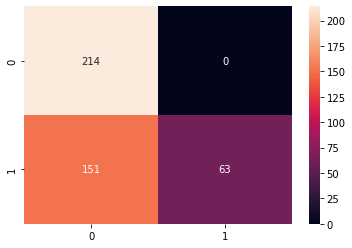

In [45]:
# testar
grid_if_predictions = best_model_if.predict(norm_X_data_teste)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia:', accuracy_score(y_data_teste, grid_if_predictions))
print('Precisao:', precision_score(y_data_teste, grid_if_predictions))
print('Recall:', recall_score(y_data_teste, grid_if_predictions))
print('F1-score:', f1_score(y_data_teste, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
#print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_data_teste, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# SVM One Class

Melhores hiperparametros do modelo: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.01}

Acuracia:  0.4658385093167702
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       161
           1       0.41      0.16      0.23       161

    accuracy                           0.47       322
   macro avg       0.45      0.47      0.41       322
weighted avg       0.45      0.47      0.41       322



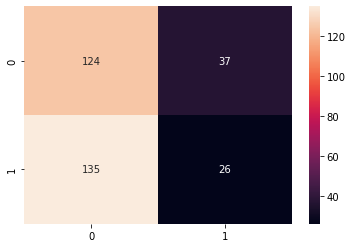

In [31]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'gamma': ['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'nu': [0.01, 0.1, 0,5, 1]}

#grid_svm = OneClassSVM(gamma='scale', nu=0.01) #GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm = GridSearchCV(OneClassSVM(),param_grid_svm, refit=True, scoring="recall", n_jobs=-1)
grid_svm.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_svm, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_svm_predictions[grid_svm_predictions == 1] = 0
grid_svm_predictions[grid_svm_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_svm_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

In [32]:
grid_svm_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [33]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Florestas isoladas

Melhores hiperparametros do modelo: {'bootstrap': True, 'contamination': 0.001, 'max_features': 5, 'max_samples': 100, 'n_estimators': 100}

Acuracia:  0.5031055900621118
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       161
           1       0.67      0.01      0.02       161

    accuracy                           0.50       322
   macro avg       0.58      0.50      0.35       322
weighted avg       0.58      0.50      0.35       322



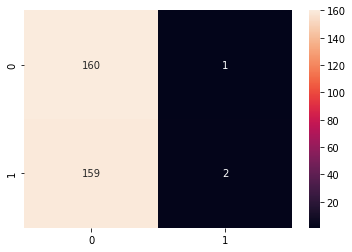

In [29]:
from sklearn.ensemble import IsolationForest

# treinar florestas isoladas

# pesquisa em grade
param_grid_if = {'n_estimators': list(range(100, 800, 5)), 
              'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]}

grid_if = GridSearchCV(IsolationForest(), param_grid_if, refit=True, scoring="precision", n_jobs=-1)
grid_if.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_if.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_if, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_if_predictions = grid_if.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')